In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
print(grid_data_file)
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))

/home/lena/Promotion/neurolib/GUI/rate/bi.pickle
147


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
dur = 500.
t0_ = dur - 20.
t_pen = t0_/dur

In [5]:
bestControl_ = [None] * len(exc) 
bestState_ = [None] * len(exc) 
cost_ = [None] * len(exc) 
costnode_ = [None] * len(exc) 
weights_ = [None] * len(exc) 
convergence_ = [None] * len(exc) 

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)
w_ = [None] * len(exc)
conv = [None] * len(exc)
conv_shift = [None] * len(exc)

In [6]:
file_ = '2_E.pickle'
folder = str(os.getcwd().split('data')[1])
print(folder)
case = str(folder[1])

/2


In [7]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if 'E' in file_:
    if case in ['1', '2']:
        c_var = [2]
    else:
        c_var = [3]
elif 'I' in file_:
    if case in ['1', '2']:
        c_var = [5]
    else:
        c_var = [4]
    
    
p_var = [0]

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [5., -5., 0.2, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [8]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]    

file found


In [63]:
# get initial parameters and target states
i_range_ = np.arange(0, 83, 1)
i_range = []
for i in i_range_:
    if type(bestControl_[i]) == type(None):
        i_range.append(i)
        
print(i_range)

[41, 44, 47, 53, 68, 74, 75, 76]


In [64]:
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  41 0.5500000000000003 0.5500000000000003
-------  44 0.47500000000000014 0.5750000000000003
-------  47 0.5500000000000003 0.5750000000000003
-------  53 0.5500000000000003 0.6000000000000003
-------  68 0.5750000000000002 0.6500000000000004
-------  74 0.5500000000000003 0.6750000000000004
-------  75 0.5750000000000002 0.6750000000000004
-------  76 0.4250000000000001 0.7000000000000004


In [65]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  41 0.5500000000000003 0.5500000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  756194.7962365937
RUN  0 , total integrated cost =  756194.7962365937
Gradient descend method:  None
RUN  0 , total integrated cost =  756194.7962365937
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  44 0.47500000000000014 0.5750000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  401498.6789492869
RUN  0 , total integrated cost =  401498.6789492869
Gradient descend method:  None
RUN  0 , total integrated cost =  401498.6789492869
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  47 0.5500000000000003 0.5750000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  751175.9333805718
RUN  0 , total integrated cost =  751175.9333805718
Gradient descend method:  None
RUN  0 , total integrated cost =  751175.9333805718
Improved o

In [73]:
bad = [76]

-------  76 0.4250000000000001 0.7000000000000004
set cost params:  1.0 1000.0 0.0
interpolate adjoint :  True True True
initial cost =  163723.01087499573
RUN  0 , total integrated cost =  163723.01087499573
Gradient descend method:  None
RUN  1 , total integrated cost =  1348.790069276681
RUN  2 , total integrated cost =  1165.2538338614531
RUN  3 , total integrated cost =  997.3847367771226
RUN  4 , total integrated cost =  873.2760950993917
RUN  5 , total integrated cost =  746.7457573811108
RUN  6 , total integrated cost =  652.8591147046122
RUN  7 , total integrated cost =  566.4751366116287


ERROR:root:Problem in initial value trasfer post


RUN  8 , total integrated cost =  500.23291839098295
RUN  9 , total integrated cost =  433.3847101864487
RUN  10 , total integrated cost =  382.7004080805585
RUN  10 , total integrated cost =  382.7004080805585
Improved over  10  iterations in  0.570397307004896  seconds by  99.7662513008799  percent.
Problem in initial value trasfer post:  sigmae_f 1.5021378557747196 1.5021378739890838


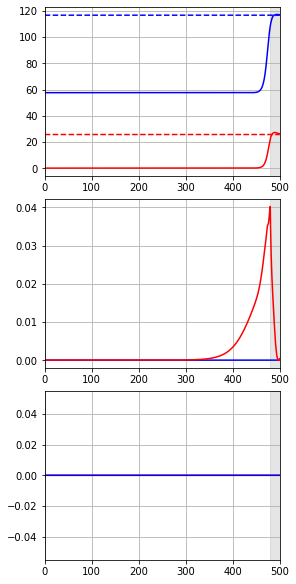

In [74]:
cgv = None
c_var = [2]

wp = 1.
w_[i] = 1000.

for i in i_range:
    
    if i < 76:
        continue

    print("------- ", i, exc[i], inh[i])
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
            
    aln.params.duration = dur
    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    control0 = 3. * bestControl_[i-1][:,:,100:-100]
    cost.setParams(wp, factor_we * w_[i], factor_ws * w_[i])
    max_it = int(10)


    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

        ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

        ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
        ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()
        
    break

-------  41 0.5500000000000003 0.5500000000000003
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  756194.7962365937
RUN  0 , total integrated cost =  756194.7962365937
Gradient descend method:  None
RUN  1 , total integrated cost =  633.0254348738056
RUN  2 , total integrated cost =  588.6180783115925
RUN  3 , total integrated cost =  268.8299909047157
Control only changes marginally.
RUN  3 , total integrated cost =  268.8299909047157
Improved over  3  iterations in  0.25982542999554425  seconds by  99.96444963754807  percent.


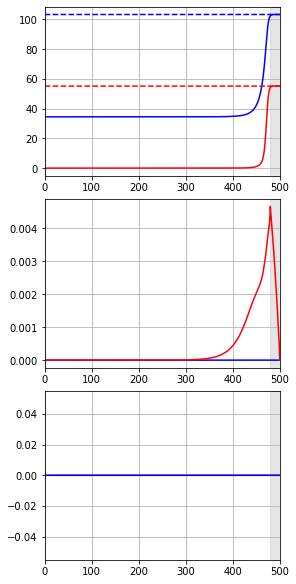

uncontrolled cost :  756194.7962365937
cost splitting :  7.5446861105422185 [0.00025926 0.         0.         0.        ]
-------  44 0.47500000000000014 0.5750000000000003
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  401498.6789492869
RUN  0 , total integrated cost =  401498.6789492869
Gradient descend method:  None
RUN  1 , total integrated cost =  11379.78578304227
RUN  2 , total integrated cost =  6763.823809247648
RUN  3 , total integrated cost =  2770.0104300156304
Control only changes marginally.
RUN  3 , total integrated cost =  2770.0104300156304
Improved over  3  iterations in  0.1968059560022084  seconds by  99.31008230531052  percent.


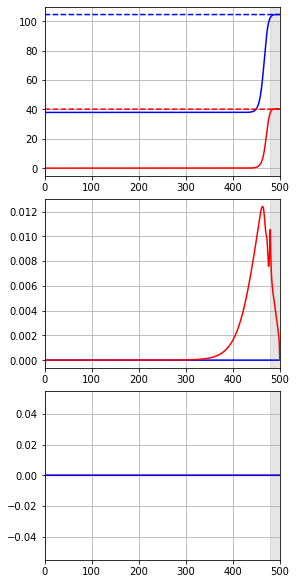

uncontrolled cost :  401498.6789492869
cost splitting :  118.6547168394837 [0.00269232 0.         0.         0.        ]
-------  47 0.5500000000000003 0.5750000000000003
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  751175.9333805718
RUN  0 , total integrated cost =  751175.9333805718
Gradient descend method:  None
RUN  1 , total integrated cost =  1192.1271854863803
RUN  2 , total integrated cost =  481.4728959369383
RUN  3 , total integrated cost =  134.7121282096863
Control only changes marginally.
RUN  3 , total integrated cost =  134.7121282096863
Improved over  3  iterations in  0.23429687599855242  seconds by  99.98206650103879  percent.


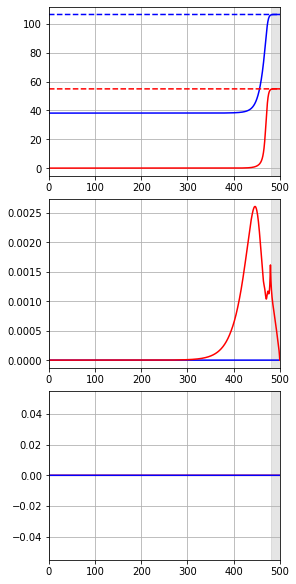

uncontrolled cost :  751175.9333805718
cost splitting :  1.0490143820046687 [0.00013098 0.         0.         0.        ]
-------  53 0.5500000000000003 0.6000000000000003
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  746144.5805987157
RUN  0 , total integrated cost =  746144.5805987157
Gradient descend method:  None
RUN  1 , total integrated cost =  1715.4454116864056
RUN  2 , total integrated cost =  1545.5052116865854
RUN  3 , total integrated cost =  127.02727016908672
RUN  4 , total integrated cost =  107.13991365938513
RUN  5 , total integrated cost =  106.90746402786311
RUN  6 , total integrated cost =  105.29140289273276
RUN  7 , total integrated cost =  102.0834908215978
Control only changes marginally.
RUN  7 , total integrated cost =  102.0834908215978
Improved over  7  iterations in  0.4647996060011792  seconds by  99.98631853752262  percent.


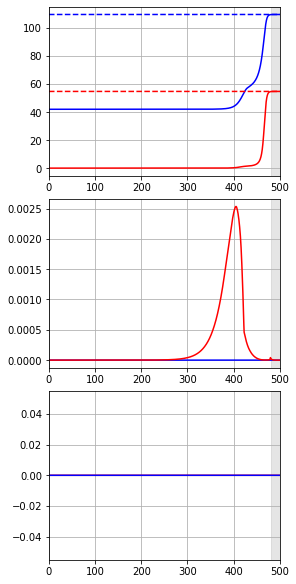

uncontrolled cost :  746144.5805987157
cost splitting :  3.56774552473416e-05 [0.00010179 0.         0.         0.        ]
-------  68 0.5750000000000002 0.6500000000000004
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  862467.9253654084
RUN  0 , total integrated cost =  862467.9253654084
Gradient descend method:  None
RUN  1 , total integrated cost =  709.9757812110167
RUN  2 , total integrated cost =  594.8448607701526
RUN  3 , total integrated cost =  165.72679896723625
Control only changes marginally.
RUN  3 , total integrated cost =  165.72679896723625
Improved over  3  iterations in  0.2366731579968473  seconds by  99.98078458408793  percent.


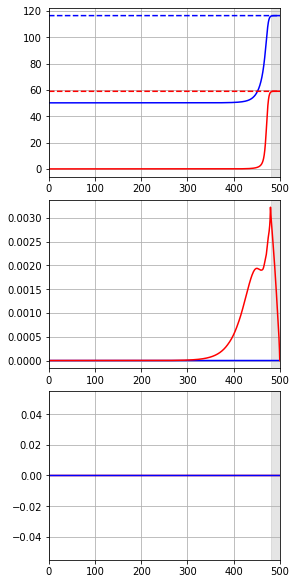

uncontrolled cost :  862467.9253654084
cost splitting :  4.362207958052817 [0.00015951 0.         0.         0.        ]
-------  74 0.5500000000000003 0.6750000000000004
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  732509.8149166821
RUN  0 , total integrated cost =  732509.8149166821
Gradient descend method:  None
RUN  1 , total integrated cost =  3183.503925895817
RUN  2 , total integrated cost =  2952.554753183916
RUN  3 , total integrated cost =  1837.8433295150444
Control only changes marginally.
RUN  3 , total integrated cost =  1837.8433295150444
Improved over  3  iterations in  0.22373474100459134  seconds by  99.7491032485723  percent.


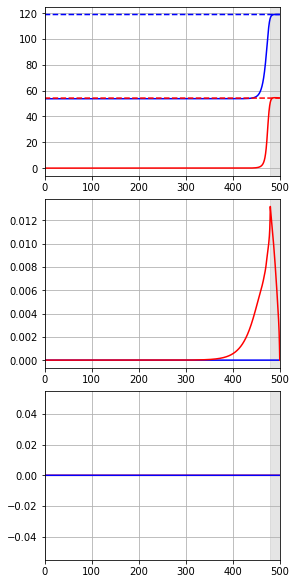

uncontrolled cost :  732509.8149166821
cost splitting :  43.90358594547761 [0.00173254 0.         0.         0.        ]
-------  75 0.5750000000000002 0.6750000000000004
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  858276.8196420075
RUN  0 , total integrated cost =  858276.8196420075
Gradient descend method:  None
RUN  1 , total integrated cost =  1008.5519716368282
RUN  2 , total integrated cost =  633.4657717704407
RUN  3 , total integrated cost =  152.95090805049782
Control only changes marginally.
RUN  3 , total integrated cost =  152.95090805049782
Improved over  3  iterations in  0.23282912500144448  seconds by  99.98217930339604  percent.


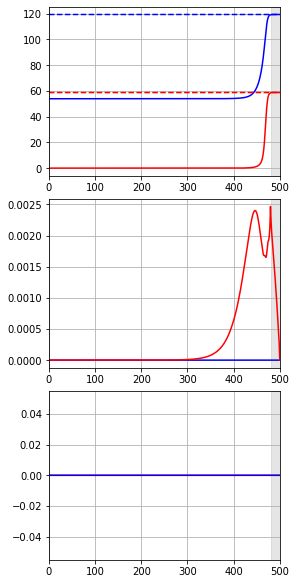

uncontrolled cost :  858276.8196420075
cost splitting :  2.6642397438690764 [0.00015225 0.         0.         0.        ]
-------  76 0.4250000000000001 0.7000000000000004
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  163736.8297408659
RUN  0 , total integrated cost =  163736.8297408659
Gradient descend method:  None
RUN  1 , total integrated cost =  163736.8297408659
Control only changes marginally.
RUN  1 , total integrated cost =  163736.8297408659
Improved over  1  iterations in  0.08212805799848866  seconds by  0.0  percent.


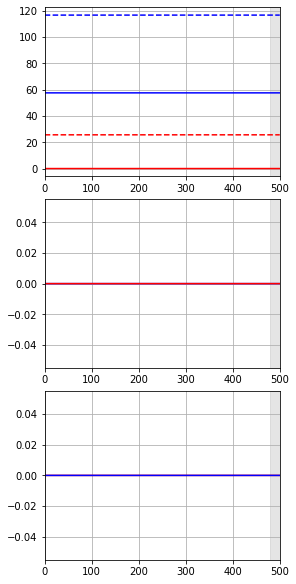

uncontrolled cost :  163736.8297408659
cost splitting :  163736.8297408659 [0. 0. 0. 0.]


In [72]:
cgv = None
j = 0
c_var = [2]

wp = 1.

for i in i_range:

    print("------- ", i, exc[i], inh[i])
    
    #if type(bestControl_[i]) != type(None)
    
    if i in bad:
        continue
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    found_exponent = False
    found_digit_0 = False
    found_digit_1 = False
    exponent = 6
    sig_digit = [1., 0.]
    
    while not found_digit_1:
        
        w_[i] = sig_digit[0] * 10**exponent + sig_digit[1] * 10**(exponent-1.)
    
        aln.params.duration = dur
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        cost.setParams(wp, factor_we * w_[i], factor_ws * w_[i])
        max_it = int(10)
        if found_digit_0:
            max_it = int(50)

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if found_exponent == False and cost_[i][-1] == 0.:
            exponent -= 1
            #continue
        elif found_exponent == False and found_digit_0 == False:
            found_exponent = True
            sig_digit[0] = 9.
        elif found_exponent == True and found_digit_0 == False and cost_[i][-1] == 0.:
            sig_digit[0] -= 1.
        elif found_exponent == True and found_digit_0 == False:
            found_digit_0 = True
            sig_digit[1] = 9.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False and cost_[i][-1] == 0.:
            sig_digit[1] -= 1.
        elif found_exponent == True and found_digit_0 == True and found_digit_1 == False:
            print("weight = ", w_[i])
            
        if True:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
                
            #with open(file_,'wb') as f:
            #    pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

            print('uncontrolled cost : ', cost_uncontrolled[i])
            print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])    

            break    
                        

In [ ]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

-------  41 0.5500000000000003 0.5500000000000003
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  27.25086751712237
RUN  0 , total integrated cost =  27.25086751712237
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  27.250504324332507
Control only changes marginally.
RUN  1 , total integrated cost =  27.250504324332507
Improved over  1  iterations in  0.23336453700176207  seconds by  0.0013327751479152994  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.8614898843135513e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  11
set cost params:  1.0 3053362959.619728 0.0
interpolate adjoint :  True True True
initial cost =  83205.68053487407
RUN  0 , total integrated cost =  83205.68053487407
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  83205.68053487407
Control only changes marginally.
RUN  1 , total integrated cost =  83205.68053487407
Improved over  1  iterations in  0.23983307299931766  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  22
set cost params:  1.0 6105725919.239456 0.0
interpolate adjoint :  True True True
initial cost =  166384.11056542373
RUN  0 , total integrated cost =  166384.11056542373
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  166384.11056542373
Control only changes marginally.
RUN  1 , total integrated cost =  166384.11056542373
Improved over  1  iterations in  0.25932048100366956  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  33
set cost params:  1.0 9158088878.859184 0.0
interpolate adjoint :  True True True
initial cost =  249562.54059597317
RUN  0 , total integrated cost =  249562.54059597317
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  249562.54059597317
Control only changes marginally.
RUN  1 , total integrated cost =  249562.54059597317
Improved over  1  iterations in  0.2675945770024555  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  44
set cost params:  1.0 12210451838.478912 0.0
interpolate adjoint :  True True True
initial cost =  332740.97062652285
RUN  0 , total integrated cost =  332740.97062652285
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  332740.97062652285
Control only changes marginally.
RUN  1 , total integrated cost =  332740.97062652285
Improved over  1  iterations in  0.25311929999588756  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  55
set cost params:  1.0 15262814798.098642 0.0
interpolate adjoint :  True True True
initial cost =  415919.40065707243
RUN  0 , total integrated cost =  415919.40065707243
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  415919.40065707243
Control only changes marginally.
RUN  1 , total integrated cost =  415919.40065707243
Improved over  1  iterations in  0.2567628850010806  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  66
set cost params:  1.0 18315177757.71837 0.0
interpolate adjoint :  True True True
initial cost =  499097.83068762283
RUN  0 , total integrated cost =  499097.83068762283
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  499097.83068762283
Control only changes marginally.
RUN  1 , total integrated cost =  499097.83068762283
Improved over  1  iterations in  0.2673320820031222  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  77
set cost params:  1.0 21367540717.338097 0.0
interpolate adjoint :  True True True
initial cost =  582276.2607181706
RUN  0 , total integrated cost =  582276.2607181706
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  582276.2607181706
Control only changes marginally.
RUN  1 , total integrated cost =  582276.2607181706
Improved over  1  iterations in  0.2604205120005645  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  88
set cost params:  1.0 24419903676.957825 0.0
interpolate adjoint :  True True True
initial cost =  665454.6907487233
RUN  0 , total integrated cost =  665454.6907487233
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  665454.6907487233
Control only changes marginally.
RUN  1 , total integrated cost =  665454.6907487233
Improved over  1  iterations in  0.259874971001409  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  99
set cost params:  1.0 27472266636.577553 0.0
interpolate adjoint :  True True True
initial cost =  748633.1207792711
RUN  0 , total integrated cost =  748633.1207792711
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  748633.1207792711
Control only changes marginally.
RUN  1 , total integrated cost =  748633.1207792711
Improved over  1  iterations in  0.29049470099562313  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.512860336025962
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576264468572
cost splitting :  3.859797401723069e-19 [2.72505043e-05 8.17114506e-32 6.53548706e-44 4.16215308e-30]
--------------- k  110
set cost params:  1.0 27749754178.361164 0.0
interpolate adjoint :  True True True
initial cost =  756194.796236595
RUN  0 , total integrated cost =  756194.796236595
Gradient descend method:  None
RUN  1 , total integrated cost =  756194.7962365937
Control only changes marginally.
RUN  1 , total integrated cost =  756194.7962365937
Improved over  1  iterations in  0.24780228600138798  seconds by  1.7053025658242404e-13  percent.
cost splitting :  3.859797401723069e-19 [0.00000000e+0

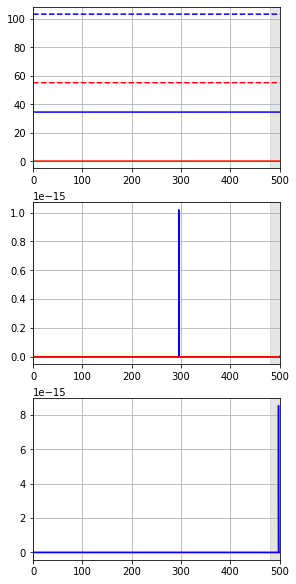

converged to zero, reload and break
file found
-------  44 0.47500000000000014 0.5750000000000003
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  1201.7629070210855
RUN  0 , total integrated cost =  1201.7629070210855
Gradient descend method:  None
RUN  1 , total integrated cost =  1201.6321115135029
Control only changes marginally.
RUN  1 , total integrated cost =  1201.6321115135029
Improved over  1  iterations in  0.25497600700327894  seconds by  0.01088363659907543  percent.
cost splitting :  5.952939110488629e-19 [1.20163211e-03 0.00000000e+00 0.00000000e+00 1.07497518e-36]
--------------- k  11
set cost params:  1.0 37644056.63784586 0.0
interpolate adjoint :  True True True
initial cost =  45234.30726366843
RUN  0 , total integrated cost =  45234.30726366843
Gradient descend method:  None
RUN  1 , total integrated cost =  45234.30726366843
Control only changes marginally.
RUN  1 , total integrated cost =  45234.30726

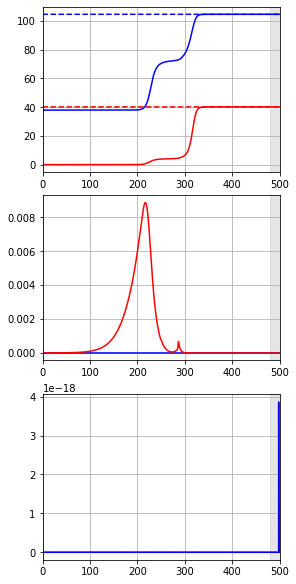

-------  47 0.5500000000000003 0.5750000000000003
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  58.78532352905007
RUN  0 , total integrated cost =  58.78532352905007
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  58.7839916319175
Control only changes marginally.
RUN  1 , total integrated cost =  58.7839916319175
Improved over  1  iterations in  0.25199281799723394  seconds by  0.002265696695374686  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.2727834274389684e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  11
set cost params:  1.0 1406533788.010447 0.0
interpolate adjoint :  True True True
initial cost =  82681.67042441505
RUN  0 , total integrated cost =  82681.67042441505
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  82681.67042441505
Control only changes marginally.
RUN  1 , total integrated cost =  82681.67042441505
Improved over  1  iterations in  0.2663439780008048  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  22
set cost params:  1.0 2812067576.020894 0.0
interpolate adjoint :  True True True
initial cost =  165304.5568571984
RUN  0 , total integrated cost =  165304.5568571984
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  165304.5568571984
Control only changes marginally.
RUN  1 , total integrated cost =  165304.5568571984
Improved over  1  iterations in  0.3046816360001685  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  33
set cost params:  1.0 4217601364.0313416 0.0
interpolate adjoint :  True True True
initial cost =  247927.44328998175
RUN  0 , total integrated cost =  247927.44328998175
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  247927.44328998175
Control only changes marginally.
RUN  1 , total integrated cost =  247927.44328998175
Improved over  1  iterations in  0.33314120999420993  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  44
set cost params:  1.0 5623135152.041788 0.0
interpolate adjoint :  True True True
initial cost =  330550.32972276537
RUN  0 , total integrated cost =  330550.32972276537
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  330550.32972276537
Control only changes marginally.
RUN  1 , total integrated cost =  330550.32972276537
Improved over  1  iterations in  0.3283487610024167  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  55
set cost params:  1.0 7028668940.052236 0.0
interpolate adjoint :  True True True
initial cost =  413173.21615554846
RUN  0 , total integrated cost =  413173.21615554846
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  413173.21615554846
Control only changes marginally.
RUN  1 , total integrated cost =  413173.21615554846
Improved over  1  iterations in  0.34421573500003433  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  66
set cost params:  1.0 8434202728.062683 0.0
interpolate adjoint :  True True True
initial cost =  495796.1025883313
RUN  0 , total integrated cost =  495796.1025883313
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  495796.1025883313
Control only changes marginally.
RUN  1 , total integrated cost =  495796.1025883313
Improved over  1  iterations in  0.34312506599962944  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  77
set cost params:  1.0 9839736516.07313 0.0
interpolate adjoint :  True True True
initial cost =  578418.9890211152
RUN  0 , total integrated cost =  578418.9890211152
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  578418.9890211152
Control only changes marginally.
RUN  1 , total integrated cost =  578418.9890211152
Improved over  1  iterations in  0.320852813005331  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  88
set cost params:  1.0 11245270304.083576 0.0
interpolate adjoint :  True True True
initial cost =  661041.8754538965
RUN  0 , total integrated cost =  661041.8754538965
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  661041.8754538965
Control only changes marginally.
RUN  1 , total integrated cost =  661041.8754538965
Improved over  1  iterations in  0.3326878840016434  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  99
set cost params:  1.0 12650804092.094025 0.0
interpolate adjoint :  True True True
initial cost =  743664.7618866824
RUN  0 , total integrated cost =  743664.7618866824
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  743664.7618866824
Control only changes marginally.
RUN  1 , total integrated cost =  743664.7618866824
Improved over  1  iterations in  0.34135300899652066  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984172651418
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129312137284
cost splitting :  1.272250637434692e-19 [5.87839916e-05 3.46238413e-21 5.47018289e-41 9.51997479e-31]
--------------- k  110
set cost params:  1.0 12778579891.004065 0.0
interpolate adjoint :  True True True
initial cost =  751175.9333805726
RUN  0 , total integrated cost =  751175.9333805726
Gradient descend method:  None
RUN  1 , total integrated cost =  751175.9333805718
Control only changes marginally.
RUN  1 , total integrated cost =  751175.9333805718
Improved over  1  iterations in  0.2976092149983742  seconds by  1.1368683772161603e-13  percent.
cost splitting :  1.272250637434692e-19 [0.00000000e+

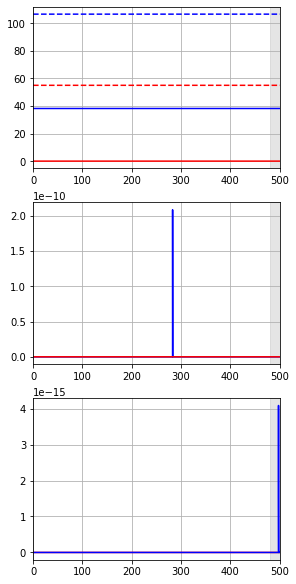

converged to zero, reload and break
file found
-------  53 0.5500000000000003 0.6000000000000003
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  97.94218301830338
RUN  0 , total integrated cost =  97.94218301830338
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  97.94091515441072
Control only changes marginally.
RUN  1 , total integrated cost =  97.94091515441072
Improved over  1  iterations in  0.26764851899497444  seconds by  0.0012945023825210455  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.981422773320411e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  11
set cost params:  1.0 838904467.5640423 0.0
interpolate adjoint :  True True True
initial cost =  82163.07128034595
RUN  0 , total integrated cost =  82163.07128034595
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  82163.07128034595
Control only changes marginally.
RUN  1 , total integrated cost =  82163.07128034595
Improved over  1  iterations in  0.2811046860006172  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  22
set cost params:  1.0 1676808935.1280847 0.0
interpolate adjoint :  True True True
initial cost =  164228.20164553818
RUN  0 , total integrated cost =  164228.20164553818
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  164228.20164553818
Control only changes marginally.
RUN  1 , total integrated cost =  164228.20164553818
Improved over  1  iterations in  0.279483865997463  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  33
set cost params:  1.0 2514713402.692127 0.0
interpolate adjoint :  True True True
initial cost =  246293.33201073005
RUN  0 , total integrated cost =  246293.33201073005
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  246293.33201073005
Control only changes marginally.
RUN  1 , total integrated cost =  246293.33201073005
Improved over  1  iterations in  0.2768462370004272  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  44
set cost params:  1.0 3352617870.2561693 0.0
interpolate adjoint :  True True True
initial cost =  328358.462375922
RUN  0 , total integrated cost =  328358.462375922
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  328358.462375922
Control only changes marginally.
RUN  1 , total integrated cost =  328358.462375922
Improved over  1  iterations in  0.27399196500482503  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  55
set cost params:  1.0 4190522337.820212 0.0
interpolate adjoint :  True True True
initial cost =  410423.5927411134
RUN  0 , total integrated cost =  410423.5927411134
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  410423.5927411134
Control only changes marginally.
RUN  1 , total integrated cost =  410423.5927411134
Improved over  1  iterations in  0.2962812039986602  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  66
set cost params:  1.0 5028426805.384254 0.0
interpolate adjoint :  True True True
initial cost =  492488.72310630465
RUN  0 , total integrated cost =  492488.72310630465
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  492488.72310630465
Control only changes marginally.
RUN  1 , total integrated cost =  492488.72310630465
Improved over  1  iterations in  0.2804990170043311  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  77
set cost params:  1.0 5866331272.948297 0.0
interpolate adjoint :  True True True
initial cost =  574553.8534714963
RUN  0 , total integrated cost =  574553.8534714963
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  574553.8534714963
Control only changes marginally.
RUN  1 , total integrated cost =  574553.8534714963
Improved over  1  iterations in  0.28840047900303034  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  88
set cost params:  1.0 6704235740.512339 0.0
interpolate adjoint :  True True True
initial cost =  656618.9838366885
RUN  0 , total integrated cost =  656618.9838366885
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  656618.9838366885
Control only changes marginally.
RUN  1 , total integrated cost =  656618.9838366885
Improved over  1  iterations in  0.29933073099527974  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  99
set cost params:  1.0 7542140208.076381 0.0
interpolate adjoint :  True True True
initial cost =  738684.1142018783
RUN  0 , total integrated cost =  738684.1142018783
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  738684.1142018783
Control only changes marginally.
RUN  1 , total integrated cost =  738684.1142018783
Improved over  1  iterations in  0.28484968800330535  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]
--------------- k  110
set cost params:  1.0 7618313341.491294 0.0
interpolate adjoint :  True True True
initial cost =  746144.5805987145
RUN  0 , total integrated cost =  746144.5805987145
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  746144.5805987145
Control only changes marginally.
RUN  1 , total integrated cost =  746144.5805987145
Improved over  1  iterations in  0.2922064579979633  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489065371
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175520859054
cost splitting :  2.9797846669138205e-20 [9.79409152e-05 4.65535220e-32 4.05456533e-44 1.55965455e-31]


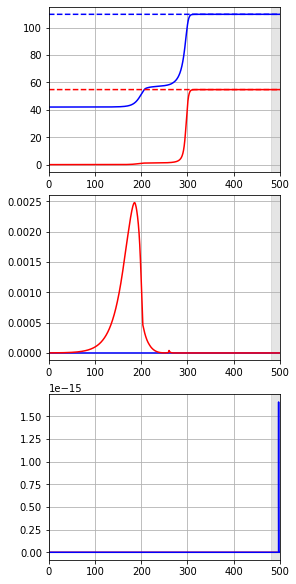

-------  68 0.5750000000000002 0.6500000000000004
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  32.44280875124857
RUN  0 , total integrated cost =  32.44280875124857
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  32.442666614449095
Control only changes marginally.
RUN  1 , total integrated cost =  32.442666614449095
Improved over  1  iterations in  0.3017438509996282  seconds by  0.00043811496274770434  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1509755455368258e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  11
set cost params:  1.0 2925170945.140975 0.0
interpolate adjoint :  True True True
initial cost =  94900.3457634815
RUN  0 , total integrated cost =  94900.3457634815
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  94900.3457634815
Control only changes marginally.
RUN  1 , total integrated cost =  94900.3457634815
Improved over  1  iterations in  0.33620473599876277  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  22
set cost params:  1.0 5849341890.28195 0.0
interpolate adjoint :  True True True
initial cost =  189768.2488603491
RUN  0 , total integrated cost =  189768.2488603491
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  189768.2488603491
Control only changes marginally.
RUN  1 , total integrated cost =  189768.2488603491
Improved over  1  iterations in  0.3404183739985456  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  33
set cost params:  1.0 8773512835.422926 0.0
interpolate adjoint :  True True True
initial cost =  284636.151957216
RUN  0 , total integrated cost =  284636.151957216
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  284636.151957216
Control only changes marginally.
RUN  1 , total integrated cost =  284636.151957216
Improved over  1  iterations in  0.3499133490040549  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  44
set cost params:  1.0 11697683780.5639 0.0
interpolate adjoint :  True True True
initial cost =  379504.0550540818
RUN  0 , total integrated cost =  379504.0550540818
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  379504.0550540818
Control only changes marginally.
RUN  1 , total integrated cost =  379504.0550540818
Improved over  1  iterations in  0.35209409299568506  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  55
set cost params:  1.0 14621854725.704876 0.0
interpolate adjoint :  True True True
initial cost =  474371.95815095067
RUN  0 , total integrated cost =  474371.95815095067
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  474371.95815095067
Control only changes marginally.
RUN  1 , total integrated cost =  474371.95815095067
Improved over  1  iterations in  0.3707072980032535  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  66
set cost params:  1.0 17546025670.84585 0.0
interpolate adjoint :  True True True
initial cost =  569239.8612478172
RUN  0 , total integrated cost =  569239.8612478172
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  569239.8612478172
Control only changes marginally.
RUN  1 , total integrated cost =  569239.8612478172
Improved over  1  iterations in  0.37729544899775647  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  77
set cost params:  1.0 20470196615.986824 0.0
interpolate adjoint :  True True True
initial cost =  664107.7643446847
RUN  0 , total integrated cost =  664107.7643446847
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  664107.7643446847
Control only changes marginally.
RUN  1 , total integrated cost =  664107.7643446847
Improved over  1  iterations in  0.35580108399881283  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  88
set cost params:  1.0 23394367561.1278 0.0
interpolate adjoint :  True True True
initial cost =  758975.6674415517
RUN  0 , total integrated cost =  758975.6674415517
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  758975.6674415517
Control only changes marginally.
RUN  1 , total integrated cost =  758975.6674415517
Improved over  1  iterations in  0.35470262300077593  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  99
set cost params:  1.0 26318538506.268776 0.0
interpolate adjoint :  True True True
initial cost =  853843.5705384202
RUN  0 , total integrated cost =  853843.5705384202
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  853843.5705384202
Control only changes marginally.
RUN  1 , total integrated cost =  853843.5705384202
Improved over  1  iterations in  0.3709346790055861  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420665603023
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520784835664
cost splitting :  2.1508169529396866e-19 [3.24426666e-05 2.55420665e-23 2.82491573e-30 3.34061706e-30]
--------------- k  110
set cost params:  1.0 26584372228.554317 0.0
interpolate adjoint :  True True True
initial cost =  862467.925365409
RUN  0 , total integrated cost =  862467.925365409
Gradient descend method:  None
RUN  1 , total integrated cost =  862467.9253654084
Control only changes marginally.
RUN  1 , total integrated cost =  862467.9253654084
Improved over  1  iterations in  0.3171384000015678  seconds by  7.105427357601002e-14  percent.
cost splitting :  2.1508169529396866e-19 [0.00000000e+00

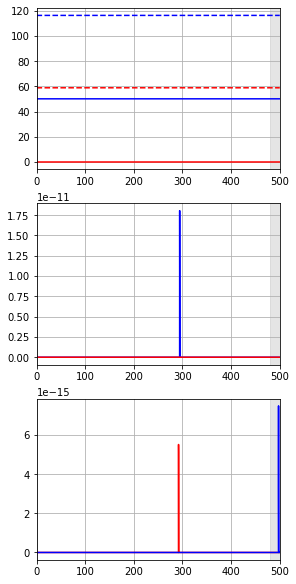

converged to zero, reload and break
file found
-------  74 0.5500000000000003 0.6750000000000004
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  212.29263355719849
RUN  0 , total integrated cost =  212.29263355719849
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  212.29245631358606
Control only changes marginally.
RUN  1 , total integrated cost =  212.29245631358606
Improved over  1  iterations in  0.33118574800028  seconds by  8.349023207188111e-05  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  11
set cost params:  1.0 380442250.8902196 0.0
interpolate adjoint :  True True True
initial cost =  80765.0199269543
RUN  0 , total integrated cost =  80765.0199269543
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  80765.0199269543
Control only changes marginally.
RUN  1 , total integrated cost =  80765.0199269543
Improved over  1  iterations in  0.29361387699464103  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  22
set cost params:  1.0 759884501.7804393 0.0
interpolate adjoint :  True True True
initial cost =  161317.7473975951
RUN  0 , total integrated cost =  161317.7473975951
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  161317.7473975951
Control only changes marginally.
RUN  1 , total integrated cost =  161317.7473975951
Improved over  1  iterations in  0.28877623099833727  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  33
set cost params:  1.0 1139326752.6706588 0.0
interpolate adjoint :  True True True
initial cost =  241870.47486823524
RUN  0 , total integrated cost =  241870.47486823524
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  241870.47486823524
Control only changes marginally.
RUN  1 , total integrated cost =  241870.47486823524
Improved over  1  iterations in  0.2984375550004188  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  44
set cost params:  1.0 1518769003.5608785 0.0
interpolate adjoint :  True True True
initial cost =  322423.2023388768
RUN  0 , total integrated cost =  322423.2023388768
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  322423.2023388768
Control only changes marginally.
RUN  1 , total integrated cost =  322423.2023388768
Improved over  1  iterations in  0.31251465500099584  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  55
set cost params:  1.0 1898211254.4510982 0.0
interpolate adjoint :  True True True
initial cost =  402975.9298095167
RUN  0 , total integrated cost =  402975.9298095167
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  402975.9298095167
Control only changes marginally.
RUN  1 , total integrated cost =  402975.9298095167
Improved over  1  iterations in  0.30616768800246064  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  66
set cost params:  1.0 2277653505.3413177 0.0
interpolate adjoint :  True True True
initial cost =  483528.65728015703
RUN  0 , total integrated cost =  483528.65728015703
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  483528.65728015703
Control only changes marginally.
RUN  1 , total integrated cost =  483528.65728015703
Improved over  1  iterations in  0.3114893750025658  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  77
set cost params:  1.0 2657095756.2315373 0.0
interpolate adjoint :  True True True
initial cost =  564081.3847507985
RUN  0 , total integrated cost =  564081.3847507985
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  564081.3847507985
Control only changes marginally.
RUN  1 , total integrated cost =  564081.3847507985
Improved over  1  iterations in  0.32264919499721145  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  88
set cost params:  1.0 3036538007.121757 0.0
interpolate adjoint :  True True True
initial cost =  644634.1122214366
RUN  0 , total integrated cost =  644634.1122214366
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  644634.1122214366
Control only changes marginally.
RUN  1 , total integrated cost =  644634.1122214366
Improved over  1  iterations in  0.3096775570011232  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  99
set cost params:  1.0 3415980258.0119762 0.0
interpolate adjoint :  True True True
initial cost =  725186.8396920776
RUN  0 , total integrated cost =  725186.8396920776
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  725186.8396920776
Control only changes marginally.
RUN  1 , total integrated cost =  725186.8396920776
Improved over  1  iterations in  0.3259318720010924  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925902304
cost splitting :  1.2198751310677275e-21 [2.12292456e-04 1.33305286e-20 8.59513839e-50 2.15847512e-33]
--------------- k  110
set cost params:  1.0 3450475008.0929055 0.0
interpolate adjoint :  True True True
initial cost =  732509.8149166829
RUN  0 , total integrated cost =  732509.8149166829
Gradient descend method:  None
RUN  1 , total integrated cost =  732509.8149166821
Control only changes marginally.
RUN  1 , total integrated cost =  732509.8149166821
Improved over  1  iterations in  0.26807014199584955  seconds by  1.1368683772161603e-13  percent.
cost splitting :  1.2198751310677275e-21 [0.00000000e+00 1.33305286e-20 8.59513839e-50 2.15847512e-33]


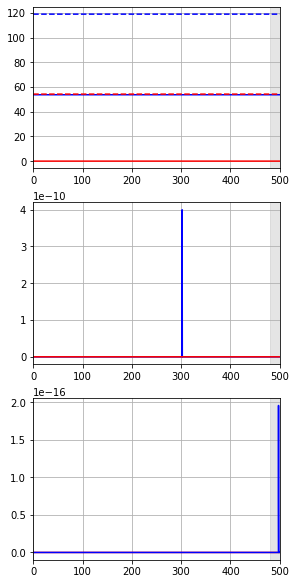

converged to zero, reload and break
file found
-------  75 0.5750000000000002 0.6750000000000004
--------------- k  0
set cost params:  1.0 1000000.0 0.0
interpolate adjoint :  True True True
initial cost =  52.21768656568045
RUN  0 , total integrated cost =  52.21768656568045
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  52.21768656568045
Control only changes marginally.
RUN  1 , total integrated cost =  52.21768656568045
Improved over  1  iterations in  0.2990640069983783  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.1046532541707088e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 3.95823350e-11]
--------------- k  11
set cost params:  1.0 1808906715.5982594 0.0
interpolate adjoint :  True True True
initial cost =  94456.92390166446
RUN  0 , total integrated cost =  94456.92390166446
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  94456.92390166446
Control only changes marginally.
RUN  1 , total integrated cost =  94456.92390166446
Improved over  1  iterations in  0.3953372960022534  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.1046532541707088e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 3.95823350e-11]
--------------- k  22
set cost params:  1.0 3616813431.196519 0.0
interpolate adjoint :  True True True
initial cost =  188861.63011676297
RUN  0 , total integrated cost =  188861.63011676297
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  188861.63011676297
Control only changes marginally.
RUN  1 , total integrated cost =  188861.63011676297
Improved over  1  iterations in  0.40837391399691114  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.1046532541707088e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 3.95823350e-11]
--------------- k  33
set cost params:  1.0 5424720146.794779 0.0
interpolate adjoint :  True True True
initial cost =  283266.3363318616
RUN  0 , total integrated cost =  283266.3363318616
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  283266.1216087725
Control only changes marginally.
RUN  1 , total integrated cost =  283266.1216087725
Improved over  1  iterations in  0.4292356289952295  seconds by  7.580254396089003e-05  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.1046532541707088e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  44
set cost params:  1.0 7232632344.487875 0.0
interpolate adjoint :  True True True
initial cost =  377671.0425247949
RUN  0 , total integrated cost =  377671.0425247949
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  377671.0425247949
Control only changes marginally.
RUN  1 , total integrated cost =  377671.0425247949
Improved over  1  iterations in  0.3681982740017702  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  55
set cost params:  1.0 9040540430.609844 0.0
interpolate adjoint :  True True True
initial cost =  472075.74874424736
RUN  0 , total integrated cost =  472075.74874424736
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  472075.74874424736
Control only changes marginally.
RUN  1 , total integrated cost =  472075.74874424736
Improved over  1  iterations in  0.3891777879980509  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  66
set cost params:  1.0 10848448516.731813 0.0
interpolate adjoint :  True True True
initial cost =  566480.4549637032
RUN  0 , total integrated cost =  566480.4549637032
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  566480.4549637032
Control only changes marginally.
RUN  1 , total integrated cost =  566480.4549637032
Improved over  1  iterations in  0.3689890910027316  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  77
set cost params:  1.0 12656356602.85378 0.0
interpolate adjoint :  True True True
initial cost =  660885.1611831548
RUN  0 , total integrated cost =  660885.1611831548
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  660885.1611831548
Control only changes marginally.
RUN  1 , total integrated cost =  660885.1611831548
Improved over  1  iterations in  0.37084605100244517  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  88
set cost params:  1.0 14464264688.97575 0.0
interpolate adjoint :  True True True
initial cost =  755289.8674026066
RUN  0 , total integrated cost =  755289.8674026066
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  755289.8674026066
Control only changes marginally.
RUN  1 , total integrated cost =  755289.8674026066
Improved over  1  iterations in  0.378113642000244  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  99
set cost params:  1.0 16272172775.097717 0.0
interpolate adjoint :  True True True
initial cost =  849694.5736220593
RUN  0 , total integrated cost =  849694.5736220593
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  849694.5736220593
Control only changes marginally.
RUN  1 , total integrated cost =  849694.5736220593
Improved over  1  iterations in  0.38147859900345793  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.504467585711557
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666974676
cost splitting :  2.103934177877319e-20 [5.22176470e-05 1.70598859e-21 7.22343296e-25 2.55339820e-31]
--------------- k  110
set cost params:  1.0 16436528055.65426 0.0
interpolate adjoint :  True True True
initial cost =  858276.8196420105
RUN  0 , total integrated cost =  858276.8196420105
Gradient descend method:  None
RUN  1 , total integrated cost =  858276.8196420075
Control only changes marginally.
RUN  1 , total integrated cost =  858276.8196420075
Improved over  1  iterations in  0.3340261690027546  seconds by  3.552713678800501e-13  percent.
cost splitting :  2.103934177877319e-20 [0.00000000e+00 

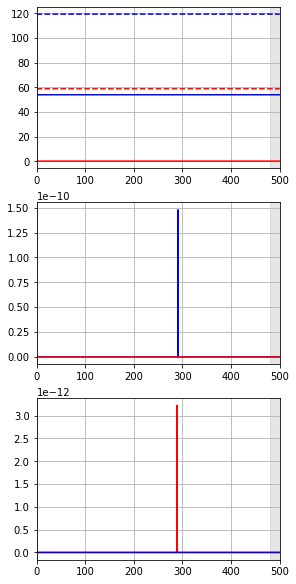

converged to zero, reload and break
file found
-------  76 0.4250000000000001 0.7000000000000004


In [80]:
tol = 1e-6
conv = [None] * len(exc)
c_var = [2,3,4,5]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    k = 0
        
    if i in bad:
        continue
        
    while not conv[i]:
        print('--------------- k ', k)
        max_it = min(1000, int(100*k))
        
        if k == 0:
            max_it = 100
            weight_ = w_[i]
        else:
            weight_ = ( cost_uncontrolled[i] - costnode_[i][0][0][0] ) / sum( costnode_[i][cost_index][0][:] )
            if k < 100:
                weight_ = w_[i] + 0.01 *k * (weight_ - w_[i])
            
        aln.params.duration = dur
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][2] == 0.:
            if k > 100:
                conv[i] = True
            else: 
                k += 10

        #print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][2:])

        if conv[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for l in range(3):
                ax[l].set_xlim(0.,dur)
                ax[l].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()

        if np.abs(target_[0,0,0] - bestState_[i][0,0,-1]) < 3.:
            with open(file_,'wb') as f:
                pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)
        else:
            print("converged to zero, reload and break")
            if os.path.isfile(file_) :
                print("file found")

                with open(file_,'rb') as f:
                    load_array = pickle.load(f)

                bestControl_ = load_array[0]
                bestState_ = load_array[1]
                cost_ = load_array[2]
                costnode_ = load_array[3]
                weights_ = load_array[4]   
            break
        
        k += 1

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  41 0.5500000000000003 0.5500000000000003
init ind =  2045
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.857460565763409e-05
RUN  0 , total integrated cost =  2.857460565763409e-05
Gradient descend method:  None
RUN  0 , total integrated cost =  2.857460565763409e-05
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.5128603320046907
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576303605227
uncontrolled cost :  756194.7962365937
cost splitting :  6.155130776947363e-25 [0. 0.]


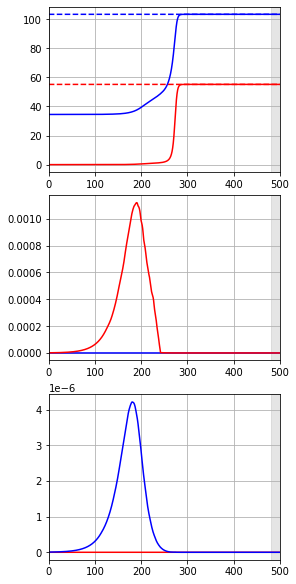

-------  44 0.47500000000000014 0.5750000000000003
init ind =  1933
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.0012100203947374216
RUN  0 , total integrated cost =  0.0012100203947374216
Gradient descend method:  None
RUN  0 , total integrated cost =  0.0012100203947374216
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
uncontrolled cost :  401498.6789492869
cost splitting :  2.4620523107789454e-24 [0. 0.]


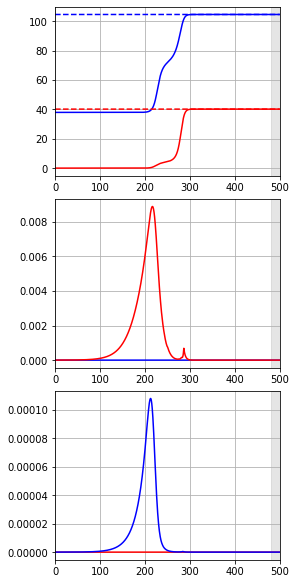

-------  47 0.5500000000000003 0.5750000000000003
init ind =  2170
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


initial cost =  6.102906304774331e-05
RUN  0 , total integrated cost =  6.102906304774331e-05
Gradient descend method:  None
RUN  0 , total integrated cost =  6.102906304774331e-05
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984159530612
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.22212932361839
uncontrolled cost :  751175.9333805718
cost splitting :  3.1403728453813175e-25 [0. 0.]


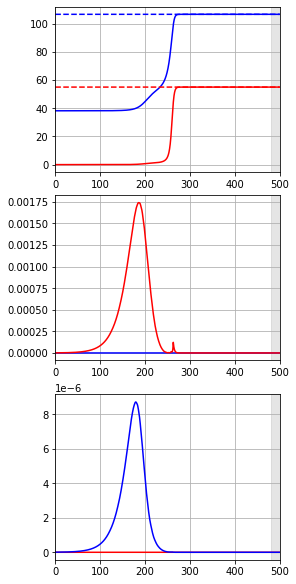

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  53 0.5500000000000003 0.6000000000000003
init ind =  2197
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  9.968678929418384e-05
RUN  0 , total integrated cost =  9.968678929418384e-05
Gradient descend method:  None
RUN  0 , total integrated cost =  9.968678929418384e-05
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436486094838
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.53175521100071
uncontrolled cost :  746144.5805987157
cost splitting :  3.1403728453813175e-25 [0. 0.]


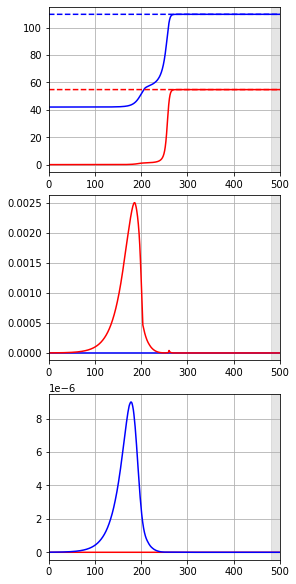

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  68 0.5750000000000002 0.6500000000000004
init ind =  2056
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  3.4292542286766784e-05
RUN  0 , total integrated cost =  3.4292542286766784e-05
Gradient descend method:  None
RUN  0 , total integrated cost =  3.4292542286766784e-05
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420637130492
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.04052081108422
uncontrolled cost :  862467.9253654084
cost splitting :  4.522136897349114e-25 [0. 0.]


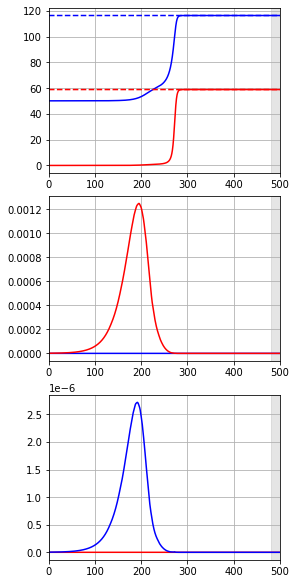

ERROR:root:Problem in initial value trasfer pre


-------  74 0.5500000000000003 0.6750000000000004
init ind =  1978
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.00021302010747526717
RUN  0 , total integrated cost =  0.00021302010747526717
Gradient descend method:  None
RUN  0 , total integrated cost =  0.00021302010747526717
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925974463
uncontrolled cost :  732509.8149166821
cost splitting :  3.1403728453813175e-25 [0. 0.]


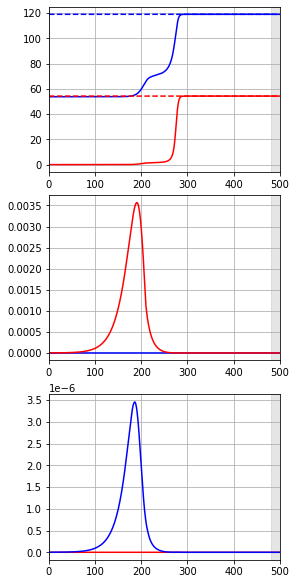

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


-------  75 0.5750000000000002 0.6750000000000004
init ind =  2090
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  5.356920844821206e-05
RUN  0 , total integrated cost =  5.356920844821206e-05
Gradient descend method:  None
RUN  0 , total integrated cost =  5.356920844821206e-05
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.5044675848949116
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.280406676857524
uncontrolled cost :  858276.8196420075
cost splitting :  2.0098386210440446e-25 [0. 0.]


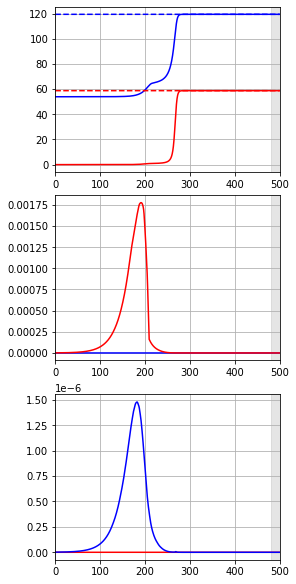

-------  76 0.4250000000000001 0.7000000000000004


In [77]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(0)
    limit = 1e-6
    
    if i in bad:
        continue
        
    for l in range( bestControl_[i].shape[2] ):
        if ( np.abs(bestControl_[i][0,2,l]) > limit or np.abs(bestControl_[i][0,3,l]) > limit
            or np.abs(bestControl_[i][0,4,l]) > limit or np.abs(bestControl_[i][0,5,l]) > limit ):
            init_ind = l - n_pre
            break
            
    if init_ind == -1:
        init_ind = 0
            
    print("init ind = ", init_ind)

    weight_ = 1.
    cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
    weights_[i] = cost.getParams()

    setinit(initVars[i], aln)

    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]

    control0 = aln.getZeroControl()
    if init_ind != 0:
        control0[:,:,:-init_ind] = bestControl_[i][:,:,n_pre-1+init_ind:-n_post+1]
    else:
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

    bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen)

    print('uncontrolled cost : ', cost_uncontrolled[i])
    print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][cost_index][0][:2])

    if True:
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
        ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
        ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

        ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

        ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
        ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

        for k in range(3):
            ax[k].set_xlim(0.,dur)
            ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
        plt.show()

In [81]:
tol = 1. * 1e-12 # 3.1
conv_shift = [None] * len(exc)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        continue
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
    max_it = int(1000)
    
    while not conv_shift[i]:
            
        weight_ = 1.
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_[i] = cost.getParams()

        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        control0 = bestControl_[i][:,:,n_pre-1:-n_post+1]

        bestControl_[i], bestState_[i], cost_[i], runtime_, grad_, phi_, phi1_, costnode_[i]= aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen)
        
        if cost_[i][-1] == 0.:
            conv_shift[i] = True

        print('uncontrolled cost : ', cost_uncontrolled[i])
        print('cost splitting : ', costnode_[i][0][0][0], costnode_[i][2][0][:])

        if False and conv_shift[i]:
            plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)
            target_ = aln.getZeroTarget()
            target_[:,0,:] = target[i][0]
            target_[:,1,:] = target[i][1]

            fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

            ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
            ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')
            ax[0].plot(plot_time_array, target_[0,0,n_pre-1:-n_post+1], linestyle = '--', color='red')
            ax[0].plot(plot_time_array, target_[0,1,n_pre-1:-n_post+1], linestyle = '--', color='blue')

            ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
            ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

            ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
            ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

            for k in range(3):
                ax[k].set_xlim(0.,dur)
                ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
            plt.show()
            
        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  41 0.5500000000000003 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  2.725050432433285e-05
RUN  0 , total integrated cost =  2.725050432433285e-05
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  2.719398354363075e-05
Control only changes marginally.
RUN  1 , total integrated cost =  2.719398354363075e-05
Improved over  1  iterations in  0.23449466000602115  seconds by  0.20741187036172448  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5128605035882532 1.5128603361998147
Problem in initial value trasfer pre:  tau_exc 19.714574633683874 19.714576262776568
uncontrolled cost :  756194.7962365937
cost splitting :  3.859797401723069e-19 [0.00000000e+00 0.00000000e+00 7.37481980e-03 4.04255985e-16
 3.61538022e-22 2.88518737e-15]
-------  44 0.47500000000000014 0.5750000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.0012016321115135026
RUN  0 , total integrated cost =  0.0012016321115135026
Gradient descend method:  None
RUN  1 , total integrated cost =  0.0012013937624721107
Control only changes marginally.
RUN  1 , total integrated cost =  0.0012013937624721107
Improved over  1  iteration

ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  5.8676404200662285e-05
Control only changes marginally.
RUN  1 , total integrated cost =  5.8676404200662285e-05
Improved over  1  iterations in  0.22862742099823663  seconds by  0.1830216497188104  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5089984866711772 1.5089984173286815
Problem in initial value trasfer pre:  tau_exc 20.22212870481313 20.222129311581295
uncontrolled cost :  751175.9333805718
cost splitting :  1.272250637434692e-19 [0.00000000e+00 0.00000000e+00 1.08329501e-02 8.32151925e-11
 1.04596203e-20 1.37985324e-15]
-------  53 0.5500000000000003 0.6000000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  9.794091515441097e-05
RUN  0 , total integrated cost =  9.794091515441097e-05
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  9.785724328563358e-05
Control only changes marginally.
RUN  1 , total integrated cost =  9.785724328563358e-05
Improved over  1  iterations in  0.21600469699478708  seconds by  0.08543096482759438  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5067436824094098 1.5067436489208503
Problem in initial value trasfer pre:  tau_exc 20.53175493676201 20.531755208474408
uncontrolled cost :  746144.5805987157
cost splitting :  2.9797846669138205e-20 [0.00000000e+00 0.00000000e+00 1.39897994e-02 3.05134469e-16
 2.84765354e-22 5.58507753e-16]
-------  68 0.5750000000000002 0.6500000000000004
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  3.244266661444937e-05
RUN  0 , total integrated cost =  3.244266661444937e-05
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  3.237933297095555e-05
Control only changes marginally.
RUN  1 , total integrated cost =  3.237933297095555e-05
Improved over  1  iterations in  0.22822602200176334  seconds by  0.19521713256951045  percent.
Problem in initial value trasfer pre:  sigmae_f 1.505842167846815 1.5058420666592094
Problem in initial value trasfer pre:  tau_exc 20.040519851084856 20.040520783923846
uncontrolled cost :  862467.9253654084
cost splitting :  2.1508169529396866e-19 [0.00000000e+00 0.00000000e+00 8.04727693e-03 7.14731650e-12
 2.37693741e-15 2.58480833e-15]
-------  74 0.5500000000000003 0.6750000000000004
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  0.0002122924563135856
RUN  0 , total integrated cost =  0.0002122924563135856
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  0.0002122859777113932
Control only changes marginally.
RUN  1 , total integrated cost =  0.0002122859777113932
Improved over  1  iterations in  0.21694775600190042  seconds by  0.003051734529293526  percent.
Problem in initial value trasfer pre:  tau_exc 21.010895883751388 21.010895925901657
uncontrolled cost :  732509.8149166821
cost splitting :  1.2198751310677275e-21 [0.00000000e+00 0.00000000e+00 2.06051439e-02 1.63282140e-10
 4.14611587e-25 6.57035025e-17]
-------  75 0.5750000000000002 0.6750000000000004
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  5.2217646983345464e-05
RUN  0 , total integrated cost =  5.2217646983345464e-05
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer pre
ERROR:root:Problem in initial value trasfer pre


RUN  1 , total integrated cost =  5.2204899487762137e-05
Control only changes marginally.
RUN  1 , total integrated cost =  5.2204899487762137e-05
Improved over  1  iterations in  0.2399531030023354  seconds by  0.024412236704947077  percent.
Problem in initial value trasfer pre:  sigmae_f 1.5044676492249998 1.5044675857193097
Problem in initial value trasfer pre:  tau_exc 20.280406116717227 20.28040666967926
uncontrolled cost :  858276.8196420075
cost splitting :  2.103934177877319e-20 [0.00000000e+00 0.00000000e+00 1.02181113e-02 5.84121322e-11
 1.20195116e-12 7.14618527e-16]
-------  76 0.4250000000000001 0.7000000000000004


-------  41 0.5500000000000003 0.5500000000000003


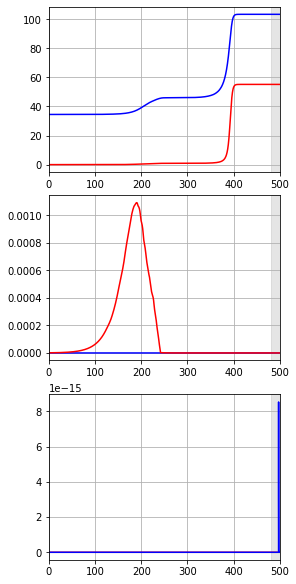

-------  44 0.47500000000000014 0.5750000000000003


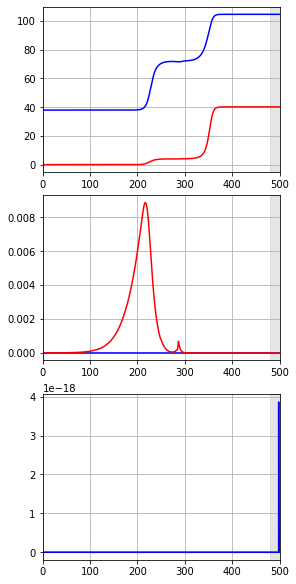

-------  47 0.5500000000000003 0.5750000000000003


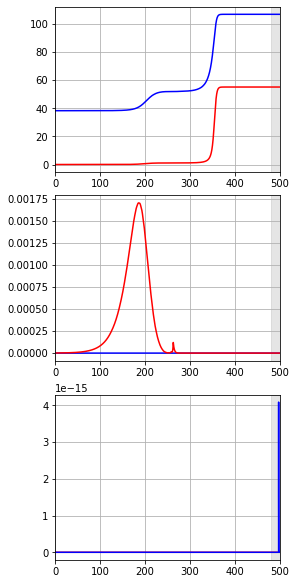

-------  53 0.5500000000000003 0.6000000000000003


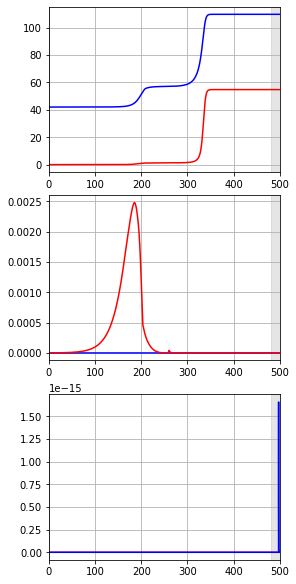

-------  68 0.5750000000000002 0.6500000000000004


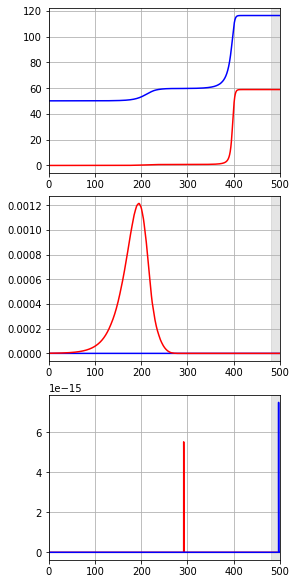

-------  74 0.5500000000000003 0.6750000000000004


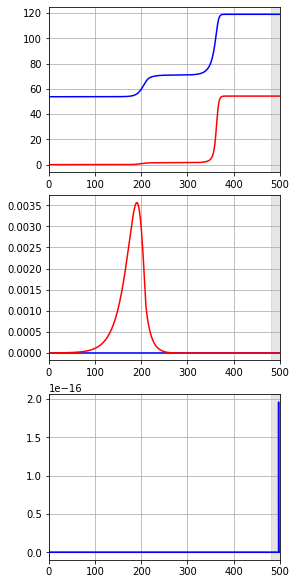

-------  75 0.5750000000000002 0.6750000000000004


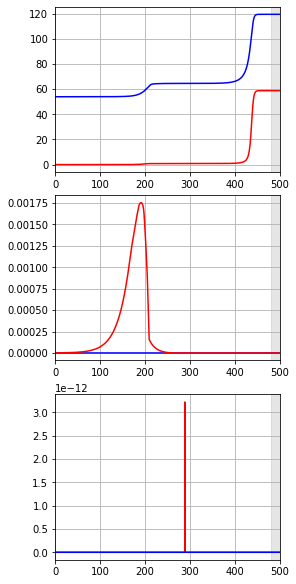

-------  76 0.4250000000000001 0.7000000000000004


In [82]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i in bad:
        bestControl_[i] = None
        continue
        
    plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)


    fig, ax = plt.subplots(3,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_[i][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_[i][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_[i][0,3,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_[i][0,2,n_pre-1:-n_post+1], color = 'red')

    ax[2].plot(plot_time_array, bestControl_[i][0,4,n_pre-1:-n_post+1], color = 'red')
    ax[2].plot(plot_time_array, bestControl_[i][0,5,n_pre-1:-n_post+1], color = 'blue')

    for k in range(3):
        ax[k].set_xlim(0.,dur)
        ax[k].axvspan(dur*t_pen, dur, alpha=0.2, color='gray')
    plt.show()